In [180]:
%load_ext autoreload
%autoreload 2
import os,sys
sys.path.append("../src_py")
import cmdstanpy
import pandas as pd
import pickle
from models.phi import PHI
from models.vae import VAE
import torch
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
from scipy.spatial.distance import cdist


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [181]:
# creating phi model
phi = PHI(2, alpha=1.0, n_centers=1000, hidden_dim1=100, hidden_dim2=100, out_dims=50)
with open('../models/2d_gp_phi.pkl', 'rb') as f:
    weights_phi = pickle.load(f)
phi.load_state_dict(weights_phi)
phi.eval()

PHI(
  (linear1): Linear(in_features=1000, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=50, bias=True)
)

In [182]:
# creating vae model
vae = VAE(input_dim=50, hidden_dim1=64, hidden_dim2=32, latent_dim=20)
with open('../models/2d_gp_vae.pkl', 'rb') as f:
    weights_vae = pickle.load(f)
vae.decoder.load_state_dict(weights_vae)
vae.decoder.eval()

Decoder(
  (linear1): Linear(in_features=20, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=50, bias=True)
)

0.0 1.0


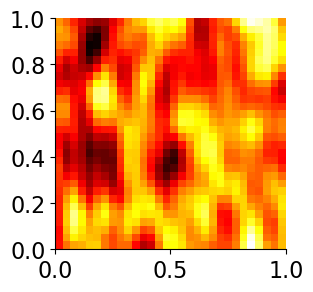

In [183]:
# data for inference
df_inf = pd.read_csv('../data/2d_gp_inf_data.csv')
x_inf = df_inf[['x1','x2']].to_numpy()

print(np.min(x_inf),np.max(x_inf))

y_inf = df_inf[['y']].to_numpy()
n = len(y_inf)
distances = cdist(x_inf,x_inf)
lengthscale = .05
K = np.exp(-0.5 * (distances / lengthscale)**2) + np.eye(n) * 1e-3
L = np.linalg.cholesky(K)
y_inf = L @ np.random.randn(n) # + np.random.randn(n) * 0.3
y_inf = y_inf / np.std(y_inf)
plt.figure(figsize=(3, 3))
plt.imshow(y_inf.reshape(30, 30), cmap='hot', extent=[0, 1, 0, 1])
plt.show()
#x_inf = x_inf[:200,:]
#y_inf = y_inf[:200]

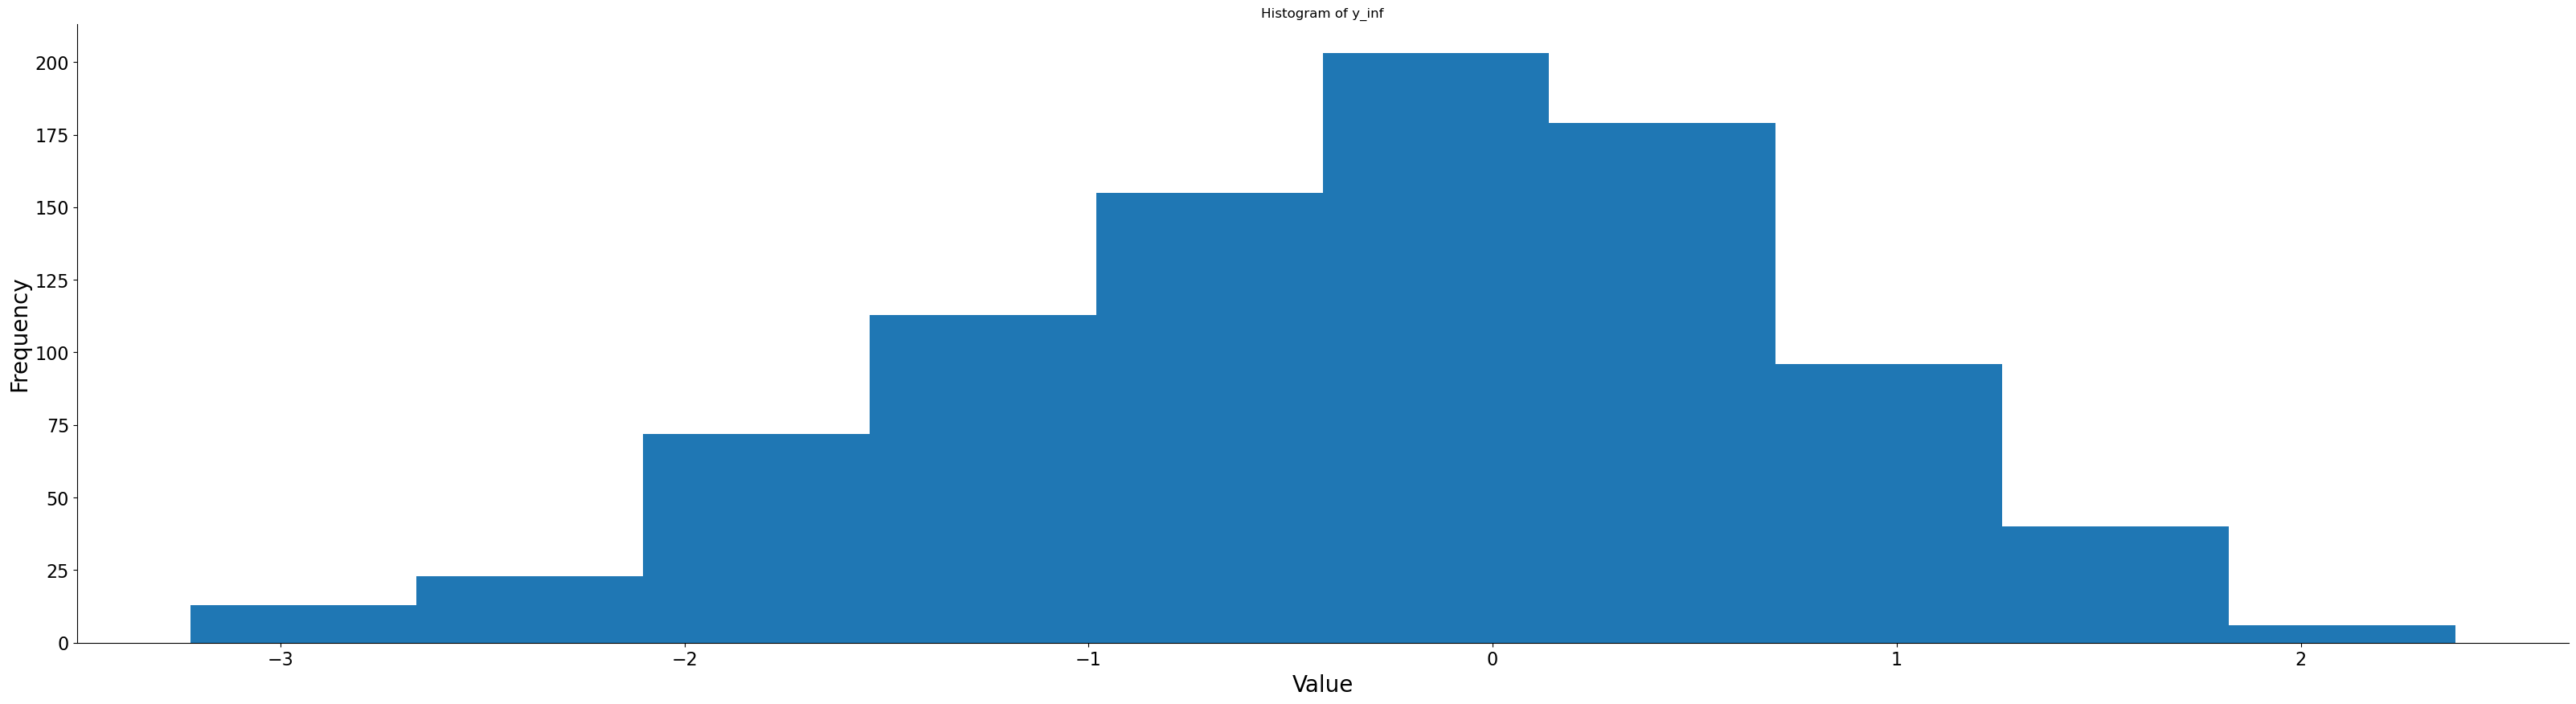

In [184]:
np.histogram(y_inf)
import matplotlib.pyplot as plt

# Assuming y_inf is the data for the histogram
plt.hist(y_inf, bins=10)  # Adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of y_inf')
plt.show()


900
(727,)


Text(0, 0.5, '$y=f(x)$')

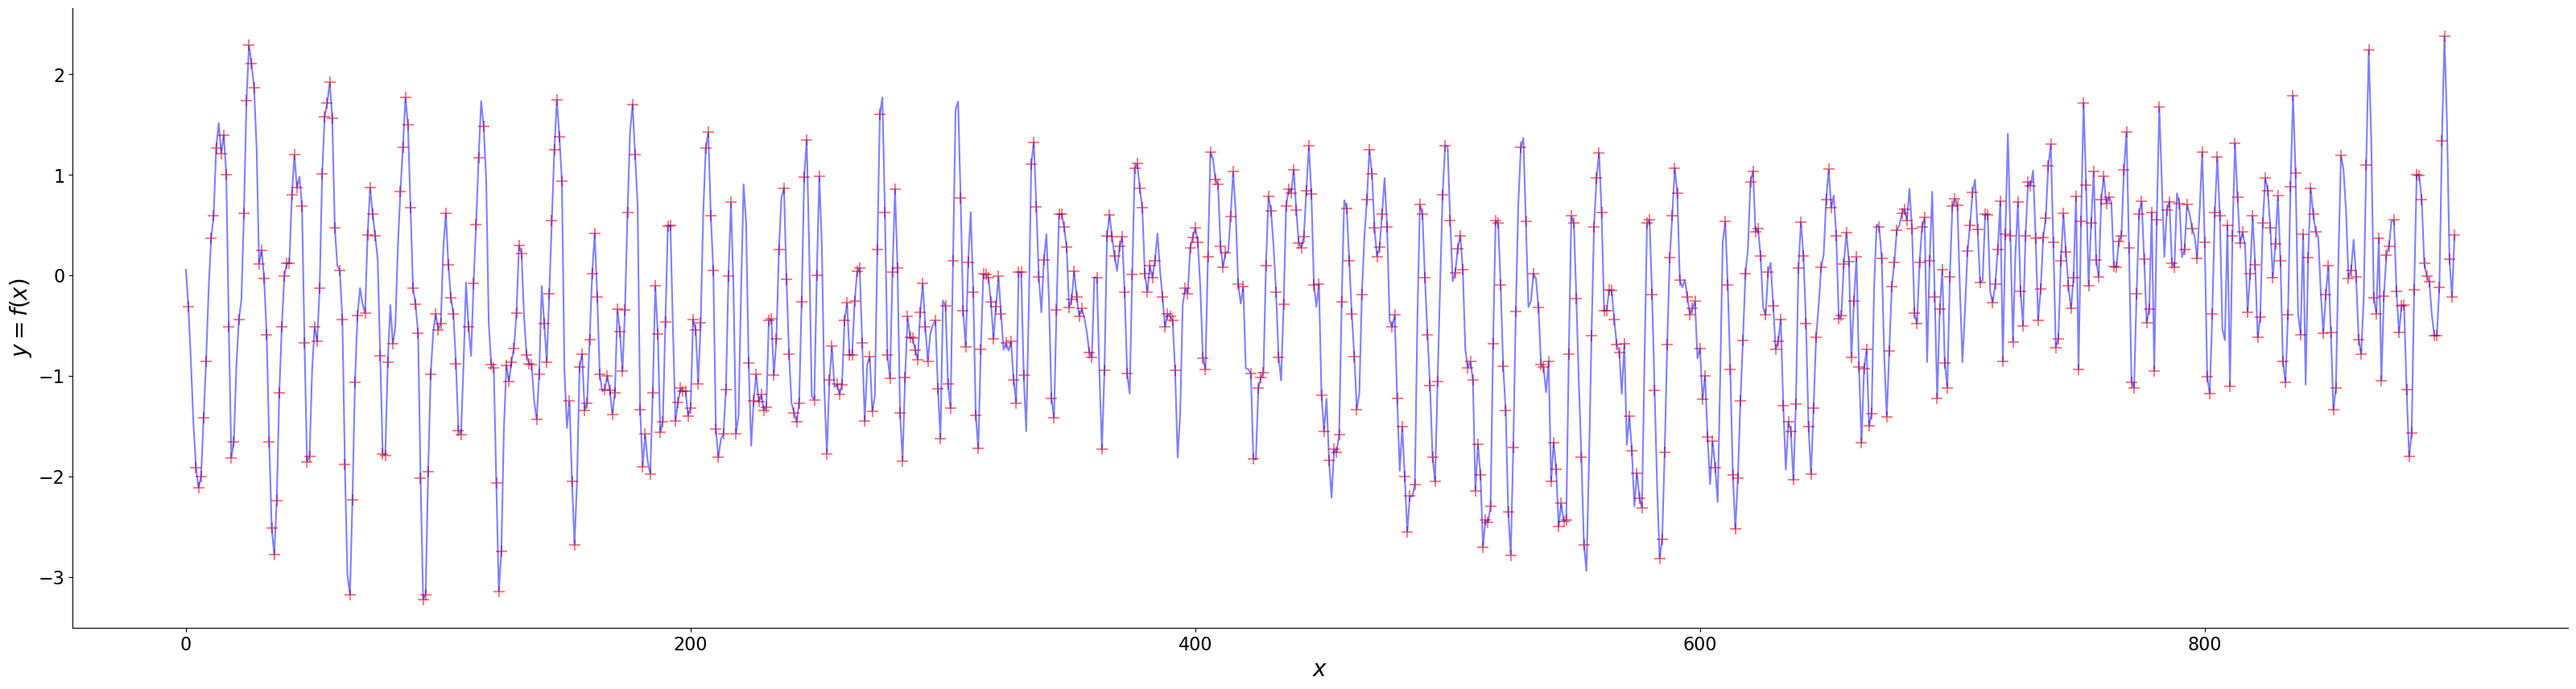

In [185]:
data_size = len(y_inf)
size = (data_size,1)
proba_0 = 0.2                 # resulting array will have 20% of zeros
idx = np.random.choice([0, 1], size=size, p=[proba_0, 1-proba_0])
ll_idx = np.where(idx)

print(data_size)
print(ll_idx[0].shape)

mpl.rc('axes.spines', right=False, top=False)
mpl.rc('axes', labelsize=20)
mpl.rc('xtick', labelsize=16, top=False)
mpl.rc('xtick.minor', visible=False)
mpl.rc('ytick', labelsize=16, right=False)
mpl.rc('ytick.minor', visible=False)
mpl.rc('legend',fontsize=16)
mpl.rc('figure', figsize=(40, 10))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y_inf, color='blue', alpha=0.5)
ax.scatter(ll_idx[0],y_inf[ll_idx[0]], marker='+', color='red', alpha=0.5, s=100)
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')

In [186]:
stan_data = {'p': 20, 
                 'p1': 64,
                 'p2': 32,
                 'n': data_size,
                 'W1': weights_vae['linear1.weight'].T.numpy(),
                 'B1': weights_vae['linear1.bias'].T.numpy(),
                 'W2': weights_vae['linear2.weight'].T.numpy(),
                 'B2': weights_vae['linear2.bias'].T.numpy(),
                 'W3': weights_vae['out.weight'].T.numpy(),
                 'B3': weights_vae['out.bias'].T.numpy(),
                 'beta_dim' : 50,
                 'phi_x' : phi(torch.tensor(x_inf).float()).detach().numpy(),
                 'y': y_inf.reshape(data_size,),
                 'll_len' : ll_idx[0].shape[0],
                 'll_idxs' : ll_idx[0]+1,
                 'dist' : cdist(x_inf, x_inf, metric='euclidean')}

In [202]:
sm1 = cmdstanpy.CmdStanModel(stan_file='../src_stan/pivae_2d.stan')
sm2 = cmdstanpy.CmdStanModel(stan_file='../src_stan/GP_2d.stan')

15:10:39 - cmdstanpy - INFO - compiling stan file /Users/setman/Library/CloudStorage/Dropbox/Seth/Research/python/pi-vae_inference/src_stan/pivae_2d.stan to exe file /Users/setman/Library/CloudStorage/Dropbox/Seth/Research/python/pi-vae_inference/src_stan/pivae_2d
15:10:53 - cmdstanpy - INFO - compiled model executable: /Users/setman/Library/CloudStorage/Dropbox/Seth/Research/python/pi-vae_inference/src_stan/pivae_2d


In [203]:
fit1 = sm1.sample(data=stan_data, iter_sampling=2000, iter_warmup=500, chains=4)

#fit2 = sm2.sample(data=stan_data, iter_sampling=400, iter_warmup=200, chains=4)


15:10:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▎         | 00:00 Status


chain 1 |▋         | 00:00 Iteration:    1 / 2500 [  0%]  (Warmup)
chain 1 |█         | 00:01 Iteration:  100 / 2500 [  4%]  (Warmup)




chain 1 |█▊        | 00:01 Iteration:  300 / 2500 [ 12%]  (Warmup)


chain 1 |██▉       | 00:01 Iteration:  501 / 2500 [ 20%]  (Sampling)


chain 1 |███▋      | 00:01 Iteration:  700 / 2500 [ 28%]  (Sampling)




chain 1 |████▍     | 00:01 Iteration:  900 / 2500 [ 36%]  (Sampling)


chain 1 |█████▏    | 00:01 Iteration: 1100 / 2500 [ 44%]  (Sampling)




chain 1 |█████▉    | 00:02 Iteration: 1300 / 2500 [ 52%]  (Sampling)


chain 1 |██████▋   | 00:02 Iteration: 1500 / 2500 [ 60%]  (Sampling)





chain 1 |███████▍  | 00:02 Iteration: 1700 / 2500 [ 68%]  (Sampling)



chain 1 |████████▏ | 00:02 Iteration: 1900 / 2500 [ 76%]  (Sampling)




chain 1 |████████▉ | 00:02 Iteration: 2100 / 2500 [ 84%]  (Sampling)



chain 1 |███████


15:10:58 - cmdstanpy - INFO - CmdStan done processing.
15:10:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'pivae_2d.stan', line 43, column 2 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'pivae_2d.stan', line 43, column 2 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'pivae_2d.stan', line 43, column 2 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'pivae_2d.stan', line 43, column 2 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'pivae_2d.stan', line 43, column 2 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'pivae_2d.stan', line 43, column 2 to column 45)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'pivae_2d.stan', line 43, column 2 to column 45)
	Exception: normal_lpdf: 

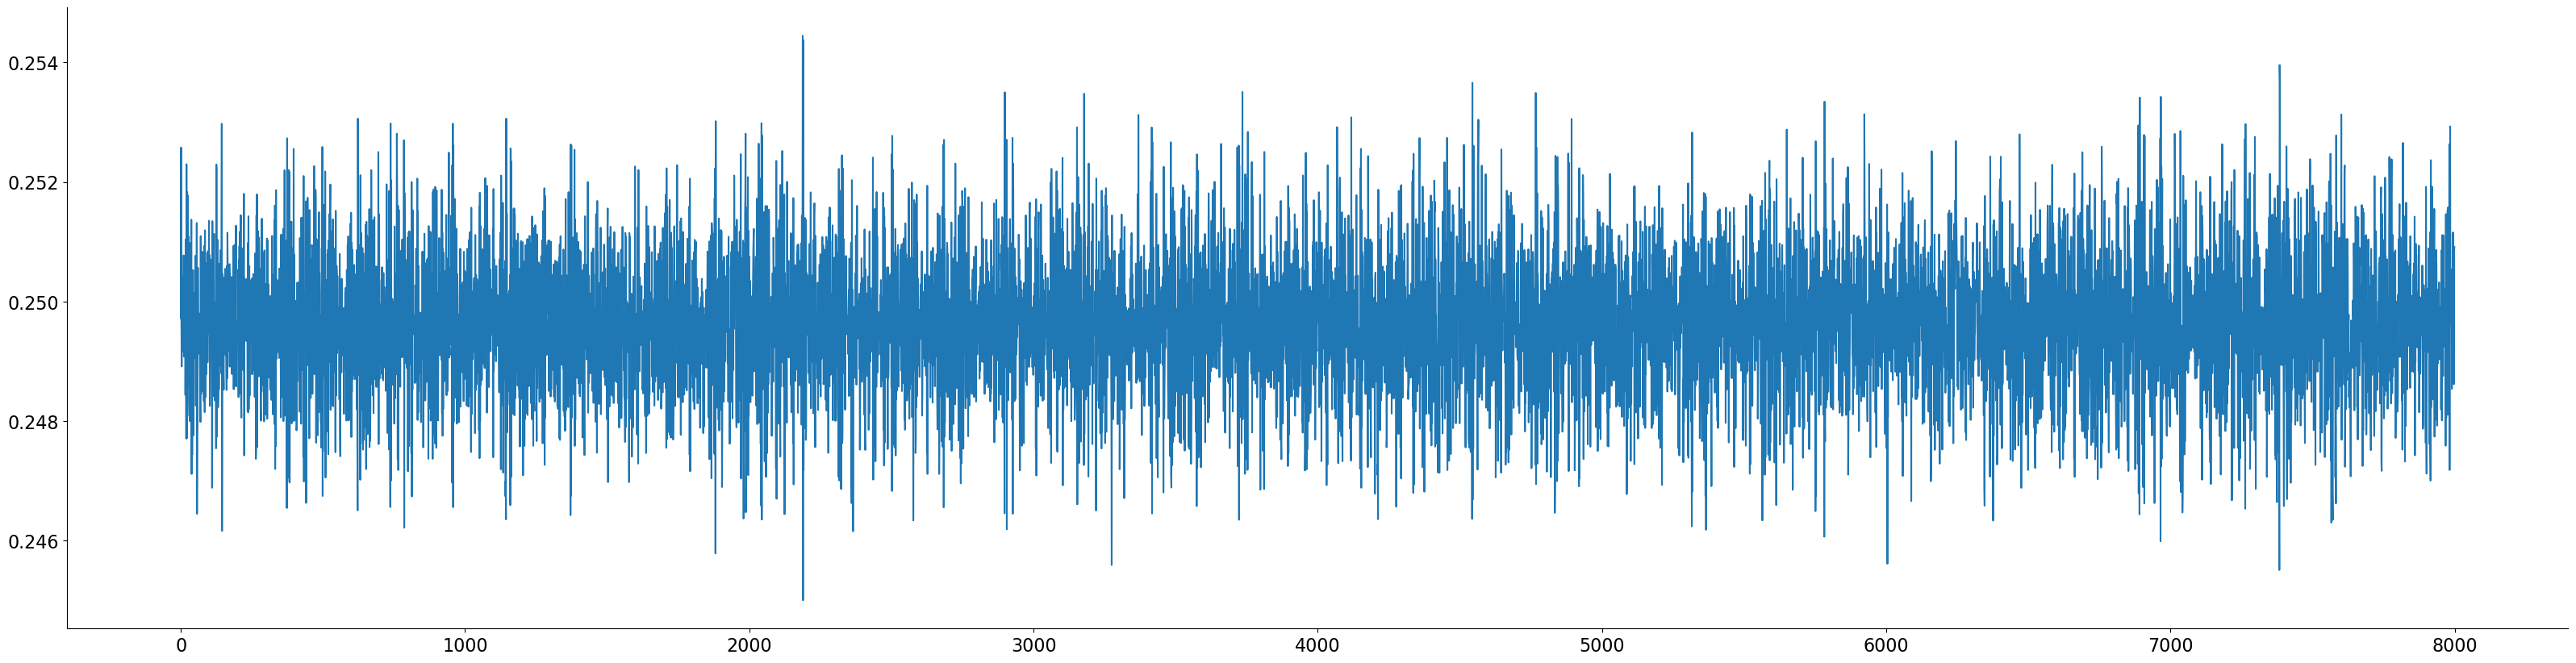

In [204]:
out = fit1.stan_variables()

df = pd.DataFrame(out['y_hat'])

plt.plot(out['sigma2'])

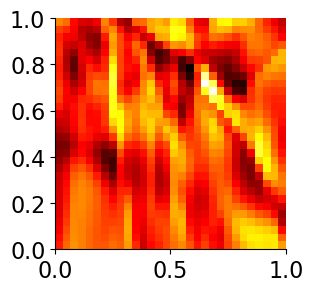

In [205]:
mpl.rc('axes.spines', right=False, top=False)
mpl.rc('axes', labelsize=20)
mpl.rc('xtick', labelsize=16, top=False)
mpl.rc('xtick.minor', visible=False)
mpl.rc('ytick', labelsize=16, right=False)
mpl.rc('ytick.minor', visible=False)
mpl.rc('legend',fontsize=16)
mpl.rc('figure', figsize=(10, 10))

plt.figure(figsize=(3, 3))
plt.imshow(df.median().to_numpy().reshape(30, 30), cmap='hot', extent=[0, 1, 0, 1])
plt.show()


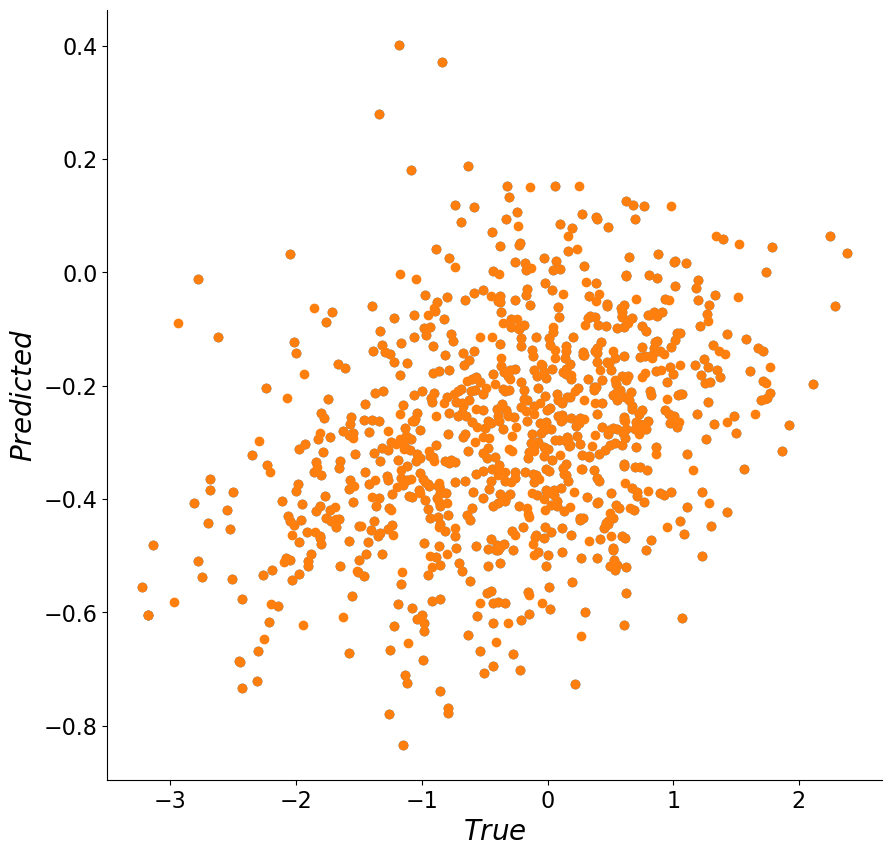

In [206]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('$True$')
ax.set_ylabel('$Predicted$')
ax.scatter(y_inf[ll_idx[0]],df.median().to_numpy()[ll_idx[0]])
ax.scatter(y_inf,df.median().to_numpy())



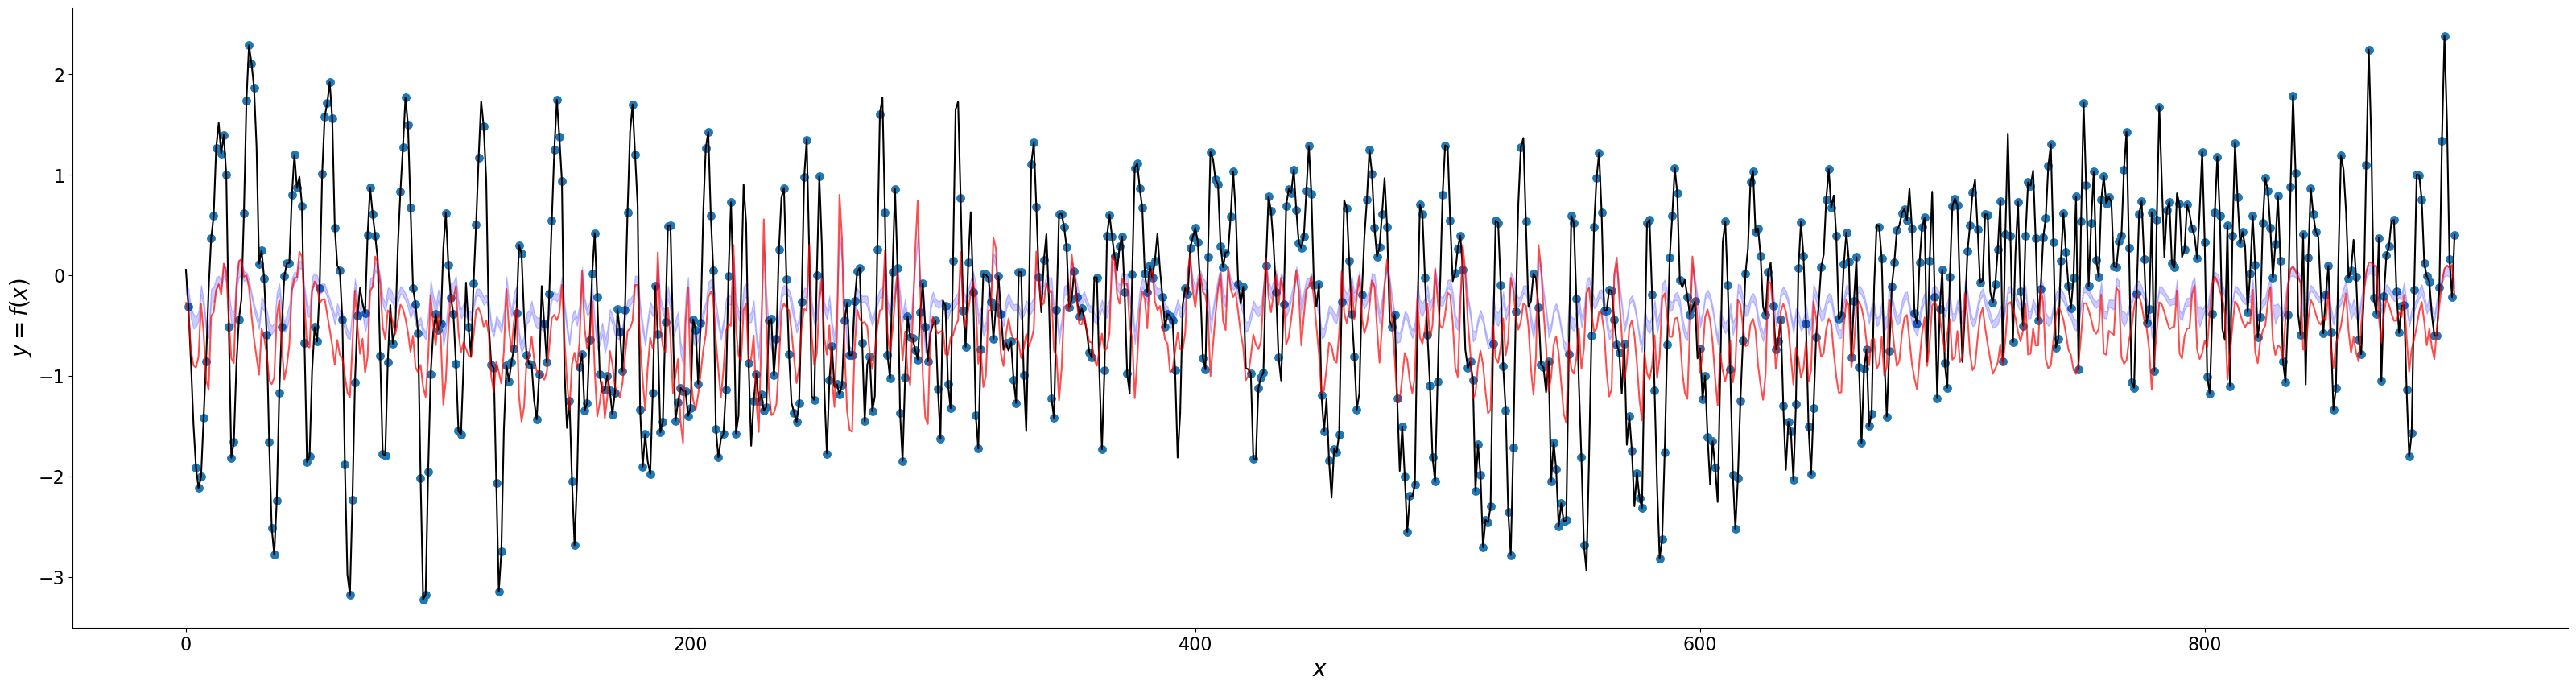

In [207]:
mpl.rc('axes.spines', right=False, top=False)
mpl.rc('axes', labelsize=20)
mpl.rc('xtick', labelsize=16, top=False)
mpl.rc('xtick.minor', visible=False)
mpl.rc('ytick', labelsize=16, right=False)
mpl.rc('ytick.minor', visible=False)
mpl.rc('legend',fontsize=16)
mpl.rc('figure', figsize=(40, 10))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.plot(y_inf, color='black', label='True')
ax.scatter(ll_idx[0], y_inf[ll_idx[0]], s=46,label = 'Observations')
ax.fill_between(range(0,data_size), df.quantile(0.025).to_numpy(), df.quantile(0.975).to_numpy(),
                    facecolor="blue",
                    color='blue', 
                    alpha=0.2, label = '95% Credible Interval')
ax.plot(df.median().to_numpy()*2, color='red', alpha=0.7, label = 'Posterior mean')